In [1]:
import numpy as np
import os,sys
import re
import pandas as pd
from io import StringIO 
import seaborn as sns
import matplotlib.pyplot as plt
from mapper import expand, parse_mapping_table, apply_mappers


In [2]:
GDSC_CNA = "../data/Gene_level_CN.csv"

gdsc = pd.read_csv('../data/Gene_level_CN.csv')
gdsc.head(3)

/Users/kbloom/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene,chr,start,stop,201T,22RV1,23132-87,42-MG-BA,451Lu,5637,...,WSU-NHL,YAPC,YH-13,YKG-1,YMB-1-E,YT,ZR-75-30,huH-1,no-10,no-11
0,NaN,NaN,NaN,NaN,1287381,924100,910924,687561,1287706,687452,...,909785,909904,909905,687592,1303911,946358,909907,1298146,908452,908450
1,DDX11L1,1,11869.0,14412.0,"-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-",...,"-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-"
2,WASH7P,1,14363.0,29806.0,"-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-",...,"-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-","-1,-1,-,-"


In [25]:
gdsc.set_index('gene',inplace = True)
gdsc.drop(["chr","start","stop"],inplace=True,axis=1)
gdsc.columns = gdsc.iloc[0,:]
gdsc = gdsc.iloc[1:,:]
gdsc.columns.name = None
# replace 2001-12-01 with DEC1 and get remove gene names converted to datetimes
gdsc.index.values[37778] = "DEC1"
df_size = gdsc.shape[0]
ndxs=pd.Series(gdsc.index).apply(lambda x : type(x) == str)
gdsc = gdsc.loc[gdsc.index.values[ndxs[ndxs].index],:]
print(df_size - gdsc.shape[0],"gene IDs excluded due to string to datetime conversion in Excel.")

gdsc.index.name = "gene_id"
ids = gdsc.index
ids = list(set(ids[ids.duplicated()]))
print("Strings containing duplicated gene IDs:",gdsc.loc[ids,:].shape[0])

0 gene IDs excluded due to string to datetime conversion in Excel.
Strings containing duplicated gene IDs: 0


In [27]:
def define_avg_ploidy(col):
    n,pl = 0,0
    CN_non_disrupted = []
    for code in col.values:
        if not code == "-1,-1,-,-":
            [max_cn,min_cn,zygosity,disruption] = code.split(",")
            n+=1
            cn = (int(max_cn)+int(min_cn))*0.5
            pl += cn
            if not disruption == "D":
                CN_non_disrupted.append((cn))
    return pd.Series({"avg_pl":pl/n , "median_pl":np.median(CN_non_disrupted)})


In [28]:
GDSC_Ploidies = "../data/PICNIC_average_ploidies.tsv"
GDSC_Ploidies = pd.read_csv(GDSC_Ploidies,sep = "\t")
GDSC_Ploidies.drop("#sample_name",axis = 1, inplace= True)
GDSC_Ploidies.set_index("sample_id",inplace=True)
print(GDSC_Ploidies.shape[0])
GDSC_Ploidies.dropna(inplace=True)
print(GDSC_Ploidies.shape[0])

est_ploidies = gdsc.apply(define_avg_ploidy).T
df_ploidies = pd.DataFrame.from_dict({"est. avg. ploidy from CN profile":est_ploidies["avg_pl"],"PICNIC avg. pl.":GDSC_Ploidies["average_ploidy"],
                                     "est. median. ploidy":est_ploidies["median_pl"]})


1020
1016


/Users/kbloom/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
/Users/kbloom/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7397: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes)


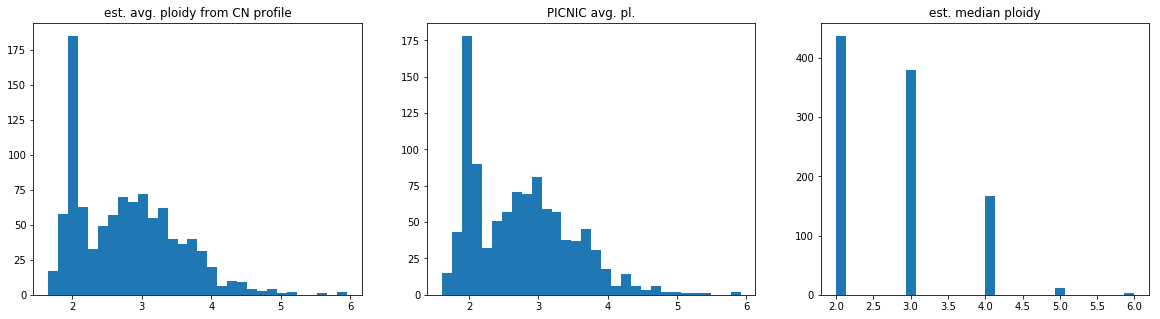

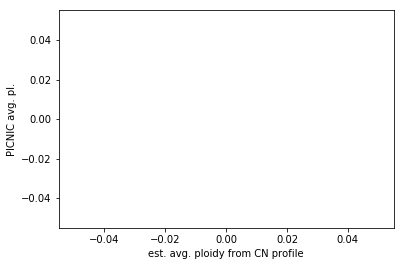

In [29]:
plt.figure(figsize=(20,5))
plt.subplot(131)
tmp = plt.hist(est_ploidies["avg_pl"],bins=30)
plt.title("est. avg. ploidy from CN profile")
plt.subplot(132)
tmp = plt.hist(sorted(list(GDSC_Ploidies["average_ploidy"].values)),bins=30)
plt.title("PICNIC avg. pl.")
plt.subplot(133)
tmp = plt.hist(est_ploidies["median_pl"],bins=30)
plt.title("est. median ploidy")

tmp = df_ploidies.plot.scatter(x = "est. avg. ploidy from CN profile",y="PICNIC avg. pl.")

In [32]:
est_ploidies.head()

,avg_pl,median_pl
1287381,3.214884,3.0
924100,2.099265,2.0
910924,2.056987,2.0
687561,3.849525,4.0
1287706,3.993492,4.0


In [39]:
df_ploidies.describe()

,est. avg. ploidy from CN profile,PICNIC avg. pl.,est. median. ploidy
count,996.000000,1016.000000,996.000000
mean,2.783733,2.753180,2.759036
std,0.732675,0.725194,0.786934
min,1.653269,1.607394,2.000000
25%,2.077135,2.054426,2.000000
50%,2.724040,2.692573,3.000000
75%,3.266711,3.220881,3.000000
max,5.949083,5.919296,6.000000


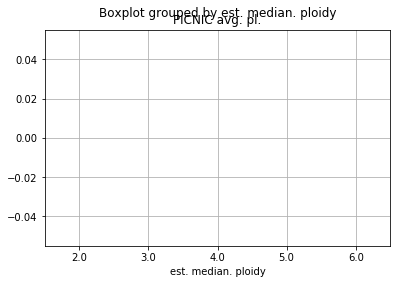

In [30]:
# PICNIC average ploidy vs estimated copy-neutral 
tmp = df_ploidies.boxplot(column="PICNIC avg. pl.", by = "est. median. ploidy" )

## Log Transform

In [38]:
estimated_CN = est_ploidies["median_pl"].to_dict()
estimated_CN['1287381']

3.0

In [46]:
num_marker_thr = 5
# to detect 1 copy gains or losses presenting at CCF >= 0.3
pos_seg_mean_thr = 0.20
neg_seg_mean_thr = -0.23 


def CN2log2R(col, median_ploidy=2 ):
    # this is fr GDSC only
    lRs = []
    genes = col.index.values
    for code in col.values:
        if not code == "-1,-1,-,-":
            [max_cn,min_cn,zygosity,disruption] = code.split(",")
            if int(max_cn) == 0:
                lRs.append(-4.32) # CN=0 with 95% purity
            else:
                max_lR = np.log2(float(max_cn)/median_ploidy)
                if not disruption == "D":
                    lRs.append(max_lR)
                else:
                    if int(min_cn) == 0:
                        min_lR = -4.32
                    else:
                        min_lR = np.log2(float(min_cn)/median_ploidy)
                    if abs(min_lR) > abs(max_lR):
                        lRs.append(min_lR)
                    else:
                        lRs.append(max_lR)
                
        else:
            lRs.append(np.NaN)
    return pd.Series(dict(zip(genes, lRs)))

def clean_logR(logR_value, pos_seg_mean_thr, neg_seg_mean_thr):
    if logR_value >= pos_seg_mean_thr:
        return logR_value 
    elif logR_value <= neg_seg_mean_thr:
            return logR_value 
    else:
        return 0
    
def handle_dups(df,corr_thr = 0.75):
    '''Detect dupliated row IDs. Merge 2 or more rows with the same ID, 
    if averaged correlation in all pairvise comparision is >= corr_thhr;\n
    otherwise drop all duplicates.  Keeps abs. max value (negative preferred).'''
    dups = df.index
    dups = list(set(dups[dups.duplicated()]))
    if len(dups)==0:
        print("No duplicated row IDs. Do nothing.")
        return df
    print(len(dups), "duplicated IDs in",df.loc[dups,:].shape[0],"rows found.")
    dups_merge = [] # if corr > corr_thr
    dups_remove = [] # corr < 
    for dup in dups:
        r = df.loc[dup,:].T.corr()
        n_dups = df.loc[dup,:].shape[0]
        r_avg = []
        for i in range(0,n_dups):
            for j in range(i+1,n_dups):
                r_avg.append(r.iloc[i,j])
        if np.average(r_avg) < corr_thr :
            #print(dup,r_avg, n_dups)
            dups_remove.append(dup)
        else:
            dups_merge.append(dup)
    
    # remove not similar duplicates
    df_size = df.shape[0]
    df = df.loc[~df.index.isin(dups_remove),:]
    print("duplicate rows removed due to low correlation of duplicated profiles",df_size -df.shape[0] )
    df_size = df.shape[0]
    
    # merge simialr duplicates
    d1 = df.loc[~df.index.isin(dups_merge),:]
    d2 = df.loc[dups_merge,:]
    d2 = d2.groupby(d2.index).agg(lambda x: -max(-x.max(),-x.min(),key= abs))
    df = pd.concat([d1,d2])
    df.sort_index(inplace=True)
    print("Merged ",df_size-df.shape[0]+len(dups_merge),"duplicated rows into",len(dups_merge),"rows")
    return df



In [42]:
gdsc = gdsc.apply(lambda x : CN2log2R(x,estimated_CN[x.name] ))
# drop genes without any determined value
gdsc = gdsc.dropna(axis=0,how="all")
# fill with zeroes the remaining ones
gdsc.fillna(0,inplace=True)
gdsc.head(3)

,1287381,924100,910924,687561,1287706,687452,906798,906797,906800,910922,...,909785,909904,909905,687592,1303911,946358,909907,1298146,908452,908450
OR4G11P,0.736966,0.0,0.0,0.321928,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.415037,0.0,0.0,-0.584963,0.321928,-1.0,-0.584963,0.584963,0.0
OR4F5,0.736966,0.0,0.0,0.321928,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.415037,0.0,0.0,-0.584963,0.321928,-1.0,-0.584963,0.584963,0.0
RP11-34P13.7,0.736966,0.0,0.0,0.321928,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.415037,0.0,0.0,-0.584963,0.321928,-1.0,-0.584963,0.584963,0.0


In [47]:
gdsc = gdsc.applymap(lambda x :  clean_logR(x, pos_seg_mean_thr, neg_seg_mean_thr))

In [3]:
NCBI = pd.read_csv("../data/Homo_sapiens.gene_info",sep = "\t")
NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
13 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
59665 Symbol can be mapped directly to GeneID


In [4]:
ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 
ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3198 Synonyms mapped to multiple GeneID
50201 different Synonyms mapped to the same GeneID
10893 Synonyms can be mapped directly to GeneID


In [7]:
NCBI.head()

,#tax_id,GeneID,Symbol,Synonyms,type_of_gene
0,9606,1,A1BG,A1B|ABG|GAB|HYST2477,protein-coding
1,9606,2,A2M,A2MD|CPAMD5|FWP007|S863-7,protein-coding
2,9606,3,A2MP1,A2MP,pseudo
3,9606,9,NAT1,AAC1|MNAT|NAT-1|NATI,protein-coding
4,9606,10,NAT2,AAC2|NAT-2|PNAT,protein-coding


In [51]:
gdsc,query2target,not_mapped  = apply_mappers(gdsc, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")
gdsc.head(3)

Mapped: 24526 
	directly via main_mapper 22100 
	via alternative mapper 805 
	via one of multiple synonyms in alternative mapper 1621 
	LOC 0 
Unmapped: 21631 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 90 
	LOC not found in Entrez 0 
	Not found at all: 21541


IDs mapped to multiple target IDs are kept:
 [143872, 140290, 414212, 414213, 341019, 51236, 414761, 442416, 728113, 26165, 6218, 221262, 100132948, 768096, 6241, 642658, 401508, 100289124, 728695, 125050, 387707, 84631, 4253, 643749, 54438, 3255, 100034743, 2749, 653505, 26824, 23254, 728798, 100462820, 119016, 26871, 286464, 51463, 642826, 653067, 100132115, 9502, 23334, 256815, 645425, 647507, 728917, 84316, 200030, 729438, 100302179, 106478953, 246126, 100033392, 92017, 374, 445815, 79741, 399761, 647060, 284565, 6551, 161176, 643479, 644509, 100418977, 29099, 10160, 653234, 644019, 114112, 79817, 463, 677844, 26583, 23523, 84458, 1517, 574445, 26095, 653308]


,1287381,924100,910924,687561,1287706,687452,906798,906797,906800,910922,...,909785,909904,909905,687592,1303911,946358,909907,1298146,908452,908450
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.584963,0.0,0.0,...,0.0,-0.584963,0.584963,0.415037,0.000000,0.000000,0.0,0.000000,0.584963,0.415037
2,0.000000,0.584963,0.0,-0.415037,0.321928,0.000000,0.584963,0.584963,0.0,0.0,...,0.0,-0.584963,0.000000,0.000000,0.736966,0.321928,0.0,-0.584963,0.000000,0.736966
9,-0.584963,0.584963,0.0,-0.415037,-0.415037,-0.584963,0.000000,0.000000,0.0,0.0,...,0.0,-0.584963,0.000000,0.415037,0.000000,0.000000,-1.0,-0.584963,0.000000,0.000000


In [52]:
gdsc = handle_dups(gdsc,corr_thr = 0.75)

80 duplicated IDs in 167 rows found.
duplicate rows removed due to low correlation of duplicated profiles 25
Merged  142 duplicated rows into 68 rows


In [53]:
gdsc.index.name = "gene_id"
gdsc = gdsc.T.sort_index().T
gdsc.head()

,1240121,1240122,1240123,1240124,1240125,1240127,1240128,1240129,1240130,1240131,...,949175,949176,949177,949178,949179,971773,971774,971777,998184,998189
gene_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.000000,0.000000,-0.415037,-0.584963,0.415037,-0.584963,0.0,...,-0.584963,-1.0,0.000000,0.0,-1.0,-0.584963,0.000000,0.0,0.0,0.0
2,0.0,0.584963,0.0,0.584963,0.000000,0.000000,0.415037,0.415037,0.000000,0.0,...,0.415037,0.0,0.415037,0.0,0.0,0.415037,-0.415037,0.0,0.0,0.0
9,-1.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.584963,-0.584963,0.415037,0.0,...,0.000000,0.0,0.000000,0.0,0.0,-0.584963,0.321928,0.0,0.0,0.0
10,-1.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.584963,-0.584963,0.415037,0.0,...,0.000000,0.0,0.000000,0.0,0.0,-0.584963,0.321928,0.0,0.0,0.0
12,0.0,0.000000,0.0,0.000000,-0.415037,-0.415037,0.000000,0.736966,0.000000,-1.0,...,-0.584963,-1.0,-0.584963,0.0,0.0,-0.584963,0.000000,0.0,0.0,0.0


In [54]:
gdsc.to_csv("../data/GDSC.Segment_Mean.CNA.tsv", sep = "\t",header=True,index=True)

In [8]:
cna_segment_mean = pd.read_csv('../data/GDSC.Segment_Mean.CNA.tsv', index_col='gene_id', sep= "\t")

In [9]:
cna_segment_mean.head()

,1240121,1240122,1240123,1240124,1240125,1240127,1240128,1240129,1240130,1240131,...,949175,949176,949177,949178,949179,971773,971774,971777,998184,998189
gene_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.000000,0.000000,-0.415037,-0.584963,0.415037,-0.584963,0.0,...,-0.584963,-1.0,0.000000,0.0,-1.0,-0.584963,0.000000,0.0,0.0,0.0
2,0.0,0.584963,0.0,0.584963,0.000000,0.000000,0.415037,0.415037,0.000000,0.0,...,0.415037,0.0,0.415037,0.0,0.0,0.415037,-0.415037,0.0,0.0,0.0
9,-1.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.584963,-0.584963,0.415037,0.0,...,0.000000,0.0,0.000000,0.0,0.0,-0.584963,0.321928,0.0,0.0,0.0
10,-1.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.584963,-0.584963,0.415037,0.0,...,0.000000,0.0,0.000000,0.0,0.0,-0.584963,0.321928,0.0,0.0,0.0
12,0.0,0.000000,0.0,0.000000,-0.415037,-0.415037,0.000000,0.736966,0.000000,-1.0,...,-0.584963,-1.0,-0.584963,0.0,0.0,-0.584963,0.000000,0.0,0.0,0.0


In [10]:
cna_segment_mean = cna_segment_mean.transpose()
cna_segment_mean.index.names = ['COSMIC_ID']
cna_segment_mean.head()



gene_id,1,2,9,10,12,13,14,15,16,18,...,107133486,107133502,107133524,107161145,107985535,107986809,107987337,107987341,109731405,112441434
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
1240121,0.0,0.000000,-1.0,-1.0,0.000000,1.584963,0.0,0.0,0.000000,0.0,...,0.000000,-4.32,0.0,0.000000,0.0,0.000000,-4.32,-4.32,0.000000,0.000000
1240122,0.0,0.584963,0.0,0.0,0.000000,1.000000,0.0,0.0,0.584963,0.0,...,0.584963,0.00,0.0,0.584963,0.0,0.584963,-4.32,-4.32,0.584963,0.584963
1240123,0.0,0.000000,0.0,0.0,0.000000,0.321928,0.0,0.0,0.321928,0.0,...,-0.415037,-4.32,0.0,0.000000,0.0,0.000000,-4.32,-4.32,0.321928,-0.415037
1240124,0.0,0.584963,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,-4.32,0.0,0.000000,0.0,0.000000,-4.32,-4.32,0.000000,0.000000
1240125,0.0,0.000000,0.0,0.0,-0.415037,0.000000,0.0,0.0,-1.000000,0.0,...,-0.415037,-2.00,0.0,0.321928,0.0,0.321928,-2.00,-2.00,-1.000000,-0.415037


In [11]:
cna_segment_mean.to_csv("../data/cna_scored_transposed.tsv",sep = "\t")